In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Disables all deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df_1 = pd.read_csv("../data/train.csv")
df_2 = pd.read_csv("../data/training_extra.csv")
df = pd.concat([df_1, df_2], axis=0)
df.set_index('id', inplace=True)
df

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...
4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470


Estou no seguinte dilema: juntei os datasets e estou investigando a relação entre as variáveis. O intuito é descobrir um modo de preenher os valores NaN nas colunas de forma condicional. O problema é que, por um lado, testes como chi quadrado e kruskal-wallis indicam que existem associação significativa entre algumas variáveis e, por outro, os gráficos não permitem ver ou entender essas relações. Vou refazer alguns testes para garantir que estou no caminho certo.

In [3]:
cat_columns = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
num_columns = ['Compartments', 'Weight Capacity (kg)']

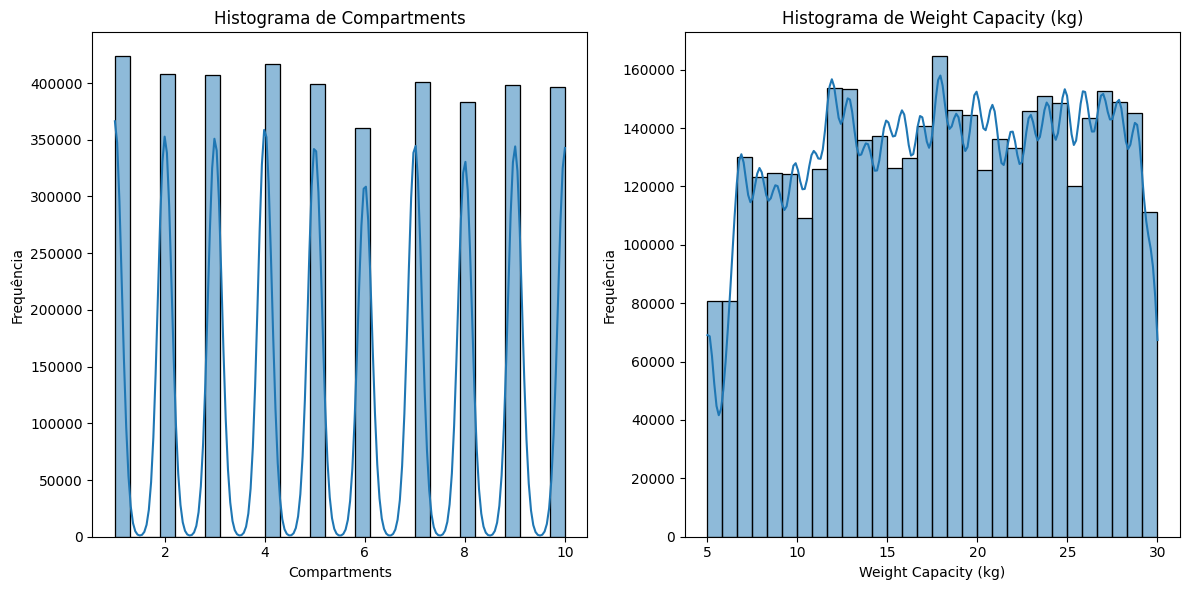

In [4]:
plt.figure(figsize=(12, 6))

# Visualização: histogramas
for i, column in enumerate(num_columns, 1):
    plt.subplot(1, len(num_columns), i)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

In [5]:
for column in num_columns:
    stat, p_value = shapiro(df[column].dropna())  # dropna() remove NaNs, pois o Shapiro não pode lidar com valores ausentes.
    print(f'Teste de Shapiro-Wilk para {column}:')
    print(f'Estatística: {stat:.3f}, P-valor: {p_value:.3f}')
    if p_value > 0.05:
        print(f'O p-valor é maior que 0.05, então não rejeitamos a hipótese nula (distribuição normal).\n')
    else:
        print(f'O p-valor é menor que 0.05, então rejeitamos a hipótese nula (não é uma distribuição normal).\n')

C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 3994318.
  res = hypotest_fun_out(*samples, **kwds)


Teste de Shapiro-Wilk para Compartments:
Estatística: 0.933, P-valor: 0.000
O p-valor é menor que 0.05, então rejeitamos a hipótese nula (não é uma distribuição normal).

Teste de Shapiro-Wilk para Weight Capacity (kg):
Estatística: 0.961, P-valor: 0.000
O p-valor é menor que 0.05, então rejeitamos a hipótese nula (não é uma distribuição normal).



C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 3992510.
  res = hypotest_fun_out(*samples, **kwds)


Confirmei que a distribuição das variáveis numéricas não é normal. Devo utilizar Kruskal-Wallis e Spearman.

In [6]:
df_num = df[['Compartments', 'Weight Capacity (kg)']]
corr_matrix_spearman = df_num.corr(method='spearman')
print(corr_matrix_spearman)

                      Compartments  Weight Capacity (kg)
Compartments              1.000000              0.003068
Weight Capacity (kg)      0.003068              1.000000


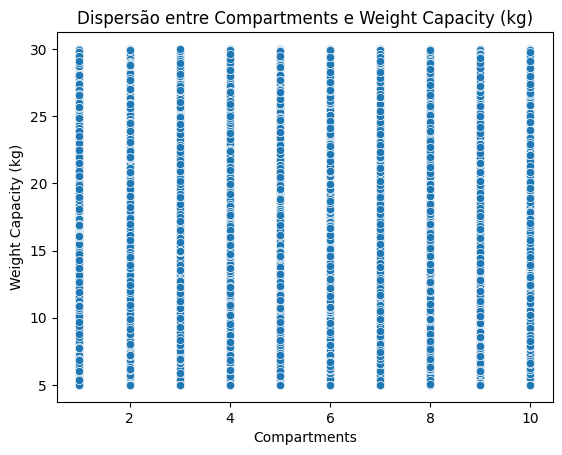

In [7]:
sns.scatterplot(data=df, x='Compartments', y='Weight Capacity (kg)')
plt.title('Dispersão entre Compartments e Weight Capacity (kg)')
plt.xlabel('Compartments')
plt.ylabel('Weight Capacity (kg)')
plt.show()

In [8]:
import pandas as pd
from scipy.stats import kruskal

df = df.dropna()

# Supondo que seu dataframe seja df
num_columns = ['Compartments', 'Weight Capacity (kg)']
cat_columns = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

# Função para aplicar o teste de Kruskal-Wallis
def kruskal_test(df, num_column, cat_column):
    # Agrupar os dados pela variável categórica
    groups = [group[num_column].values for name, group in df.groupby(cat_column)]
    
    # Aplicar o teste de Kruskal-Wallis
    stat, p_value = kruskal(*groups)
    
    # Exibir o resultado
    print(f'{num_column} vs. {cat_column}: {p_value:.3f}')
    
    # Interpretação do p-valor
    if p_value < 0.05:
        print('Há diferenças significativas entre as categorias.')
    else:
        print('Não há diferenças significativas entre as categorias.')
    print('-' * 50)

# Teste Kruskal-Wallis para cada combinação de variável numérica e categórica
for num_col in num_columns:
    for cat_col in cat_columns:
        kruskal_test(df, num_col, cat_col)

Compartments vs. Brand: 0.000
Há diferenças significativas entre as categorias.
--------------------------------------------------
Compartments vs. Material: 0.000
Há diferenças significativas entre as categorias.
--------------------------------------------------
Compartments vs. Size: 0.000
Há diferenças significativas entre as categorias.
--------------------------------------------------
Compartments vs. Laptop Compartment: 0.000
Há diferenças significativas entre as categorias.
--------------------------------------------------
Compartments vs. Waterproof: 0.000
Há diferenças significativas entre as categorias.
--------------------------------------------------
Compartments vs. Style: 0.000
Há diferenças significativas entre as categorias.
--------------------------------------------------
Compartments vs. Color: 0.005
Há diferenças significativas entre as categorias.
--------------------------------------------------
Weight Capacity (kg) vs. Brand: 0.000
Há diferenças significati

In [9]:
for column in cat_columns:
    print(df.groupby(column)['Compartments'].describe())
    print("-------------------------------------------------------")

                 count      mean       std  min  25%  50%  75%   max
Brand                                                               
Adidas        678048.0  5.440221  2.888097  1.0  3.0  5.0  8.0  10.0
Jansport      637793.0  5.418702  2.896229  1.0  3.0  5.0  8.0  10.0
Nike          651870.0  5.465967  2.886829  1.0  3.0  5.0  8.0  10.0
Puma          640818.0  5.446234  2.886909  1.0  3.0  5.0  8.0  10.0
Under Armour  679974.0  5.435092  2.886080  1.0  3.0  5.0  8.0  10.0
-------------------------------------------------------
              count      mean       std  min  25%  50%  75%   max
Material                                                         
Canvas     767843.0  5.466112  2.881399  1.0  3.0  5.0  8.0  10.0
Leather    827736.0  5.422816  2.897227  1.0  3.0  5.0  8.0  10.0
Nylon      797865.0  5.435937  2.890055  1.0  3.0  5.0  8.0  10.0
Polyester  895059.0  5.441750  2.886126  1.0  3.0  5.0  8.0  10.0
-------------------------------------------------------
         

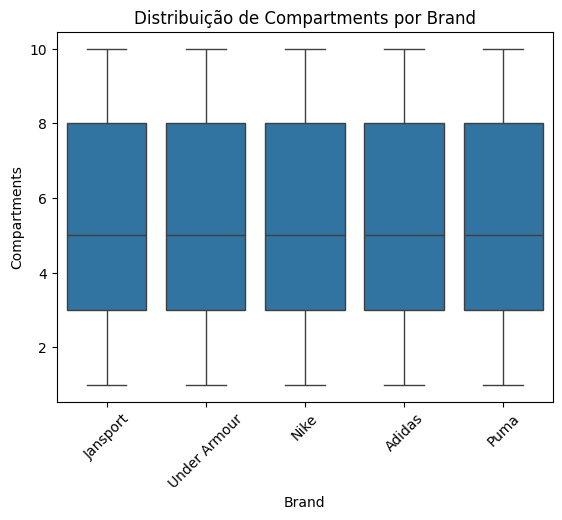

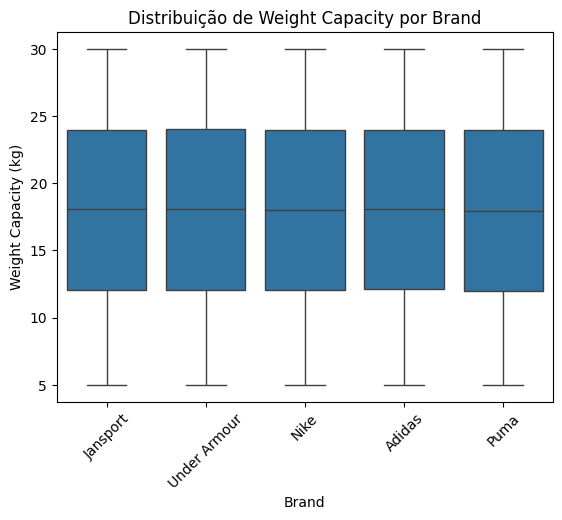

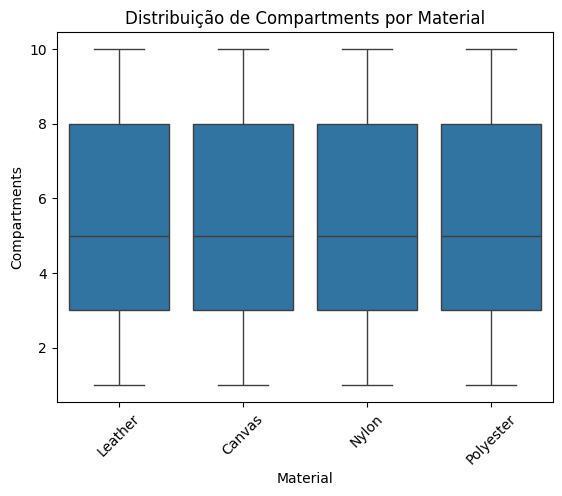

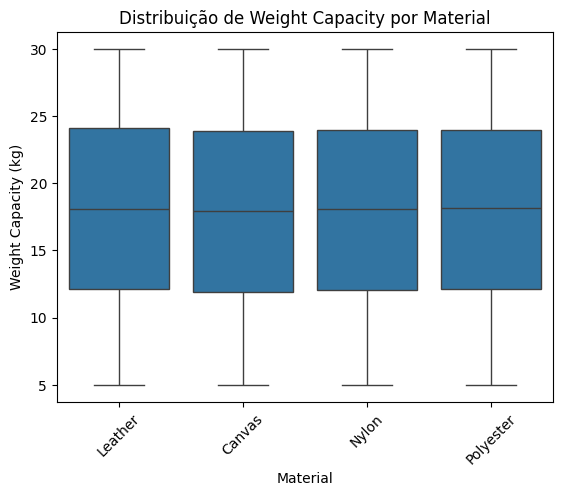

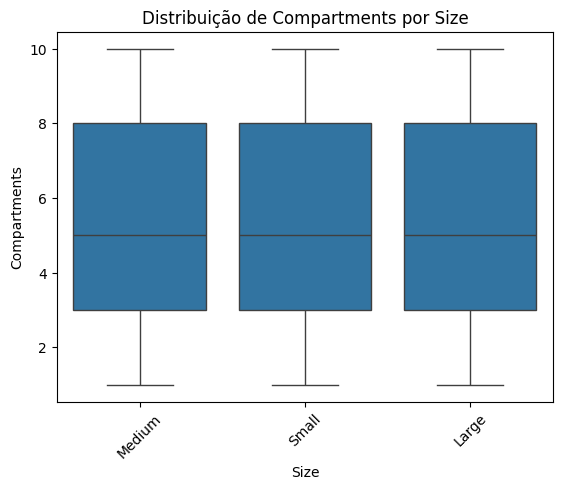

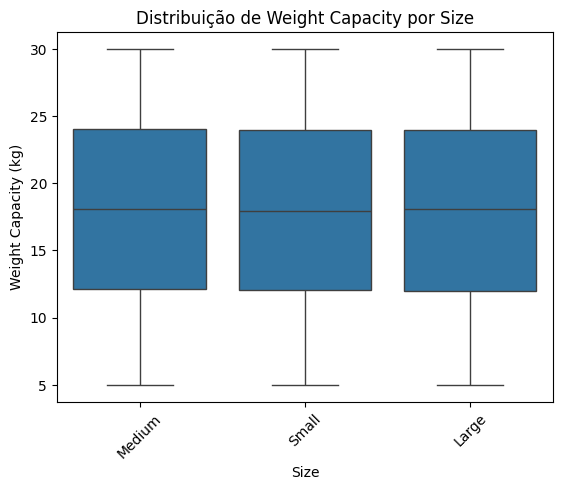

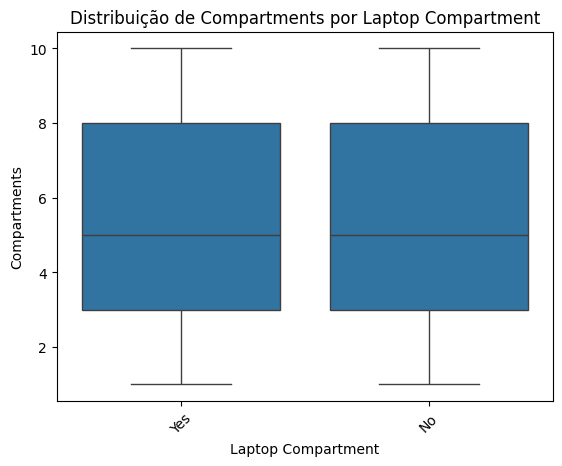

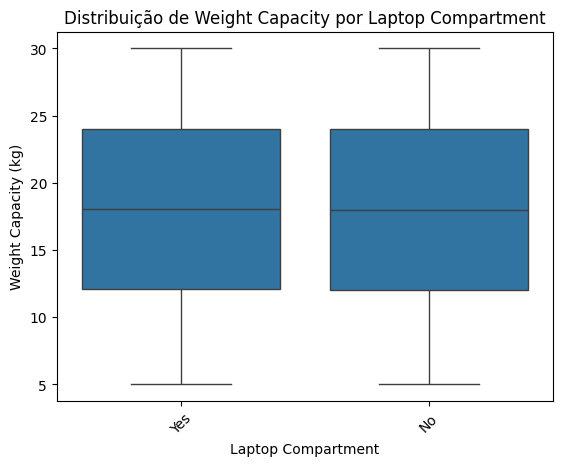

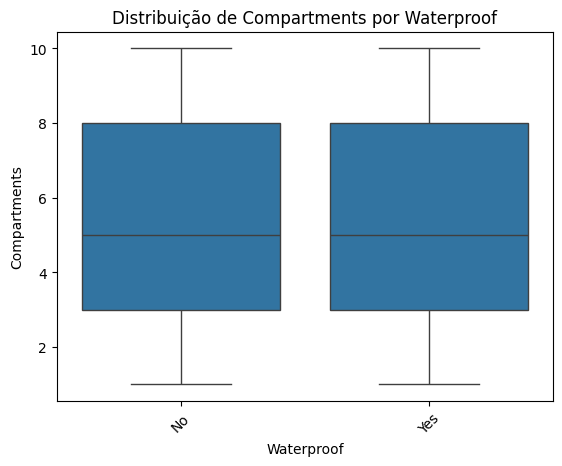

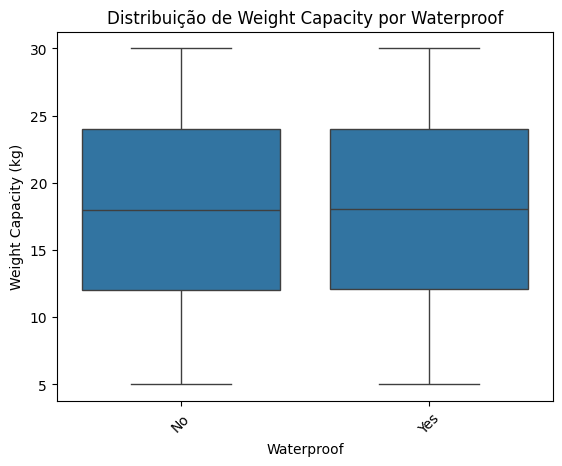

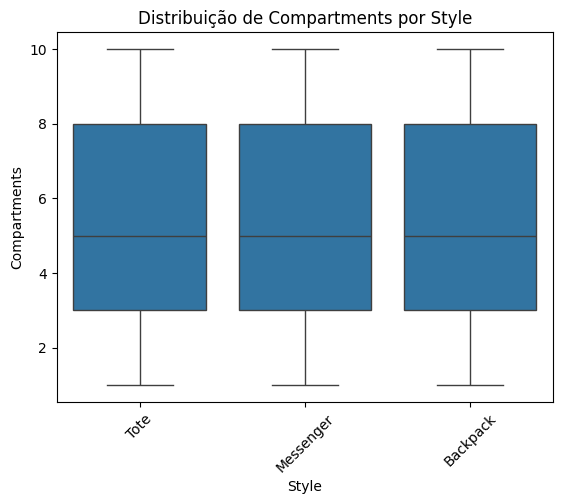

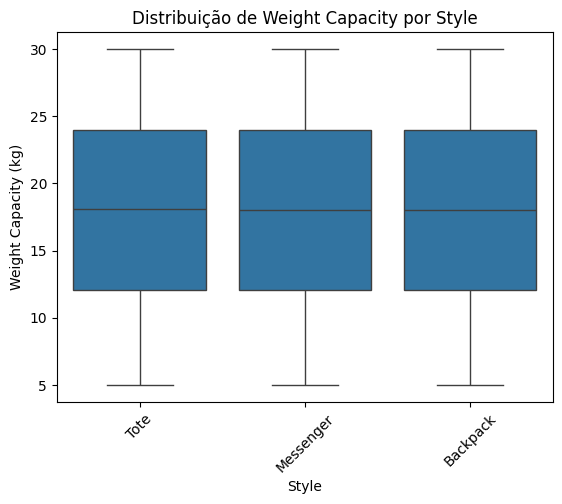

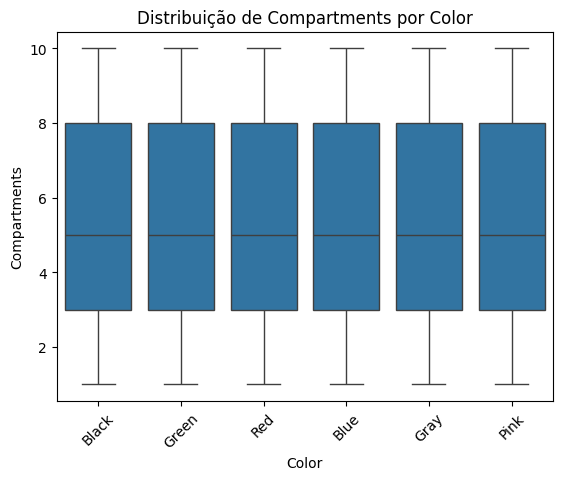

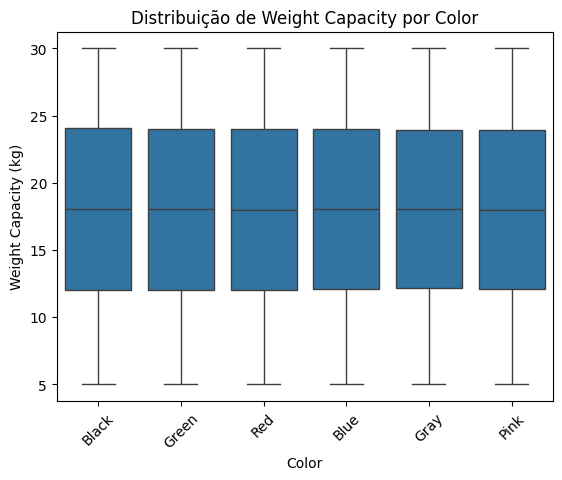

In [10]:
for column in cat_columns:
    # Boxplot para 'Compartments' por 'Brand'
    sns.boxplot(x=column, y='Compartments', data=df)
    plt.title(f"Distribuição de Compartments por {column}")
    plt.xticks(rotation=45)
    plt.show()

    # Boxplot para 'Compartments' por 'Material'
    sns.boxplot(x=column, y='Weight Capacity (kg)', data=df)
    plt.title(f"Distribuição de Weight Capacity por {column}")
    plt.xticks(rotation=45)
    plt.show()

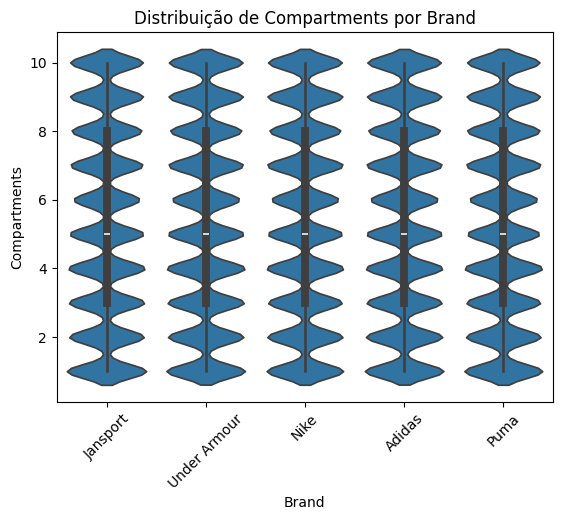

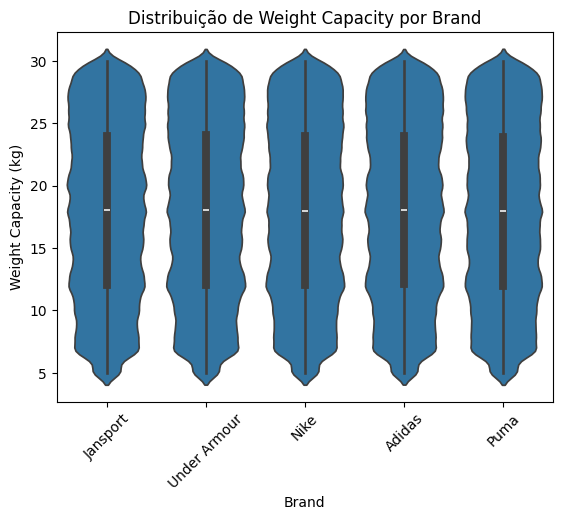

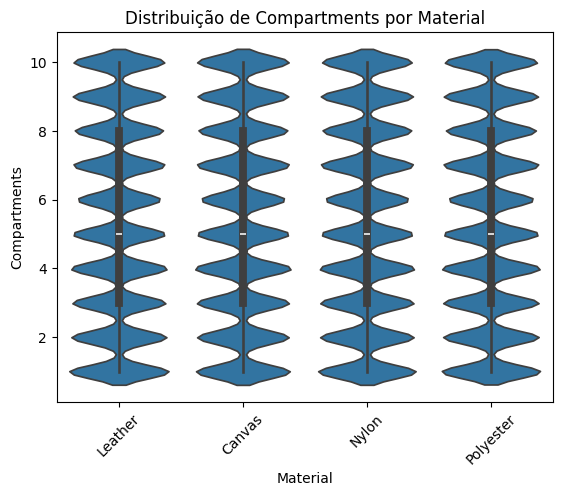

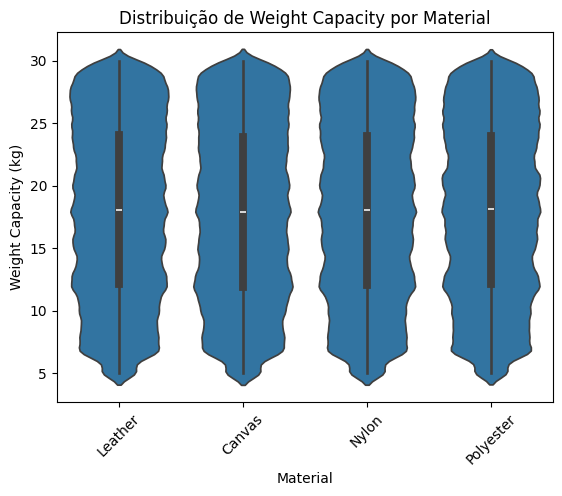

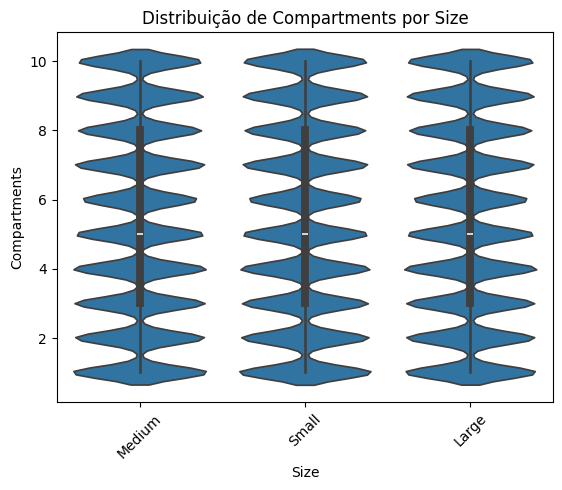

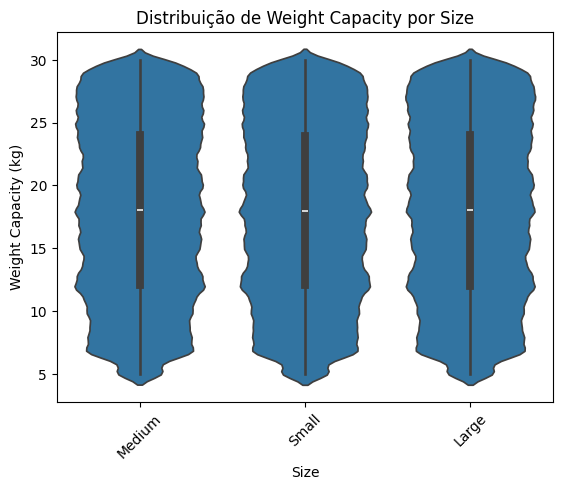

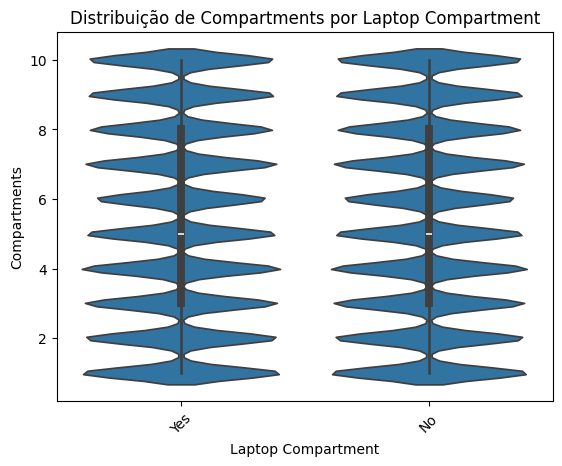

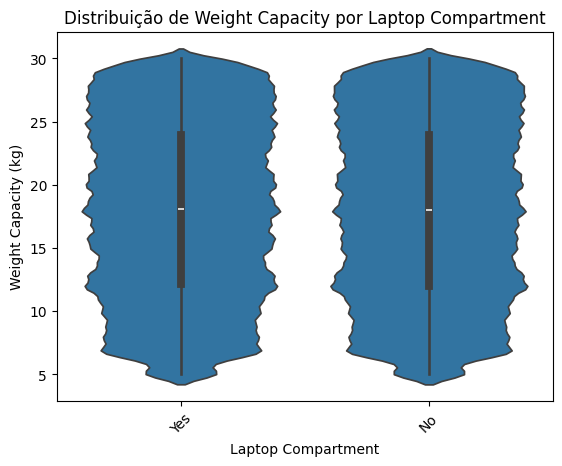

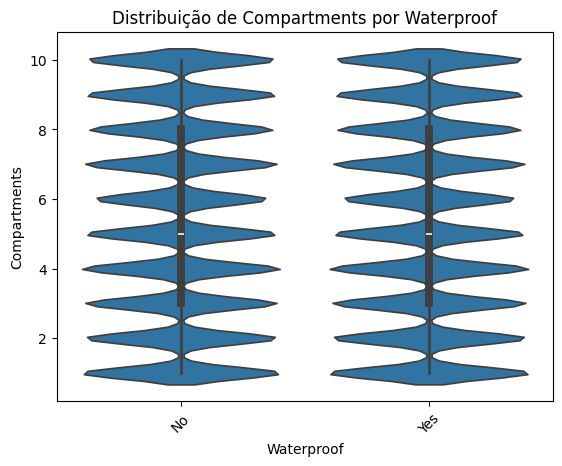

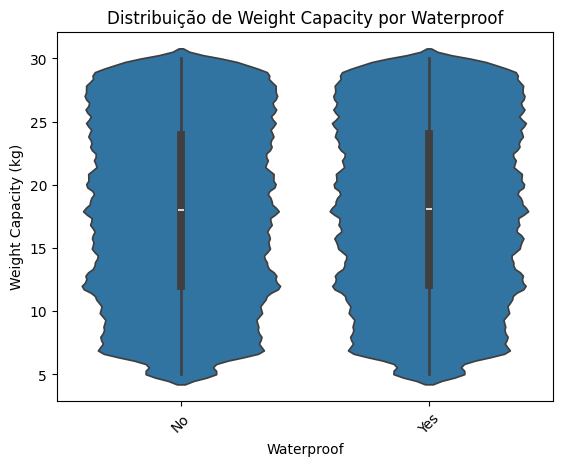

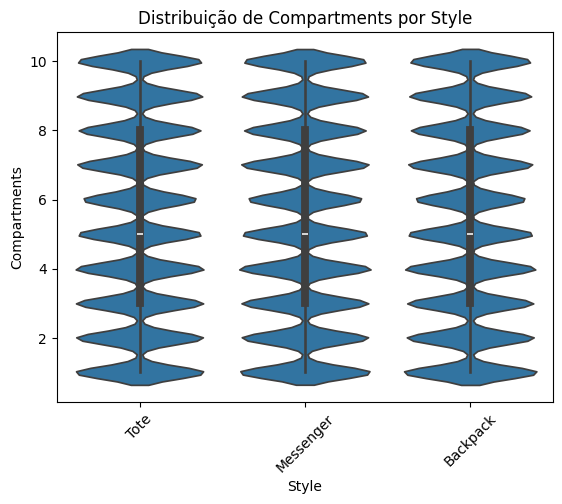

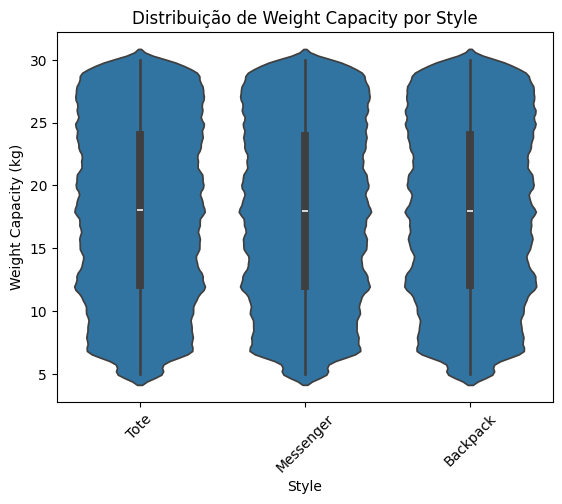

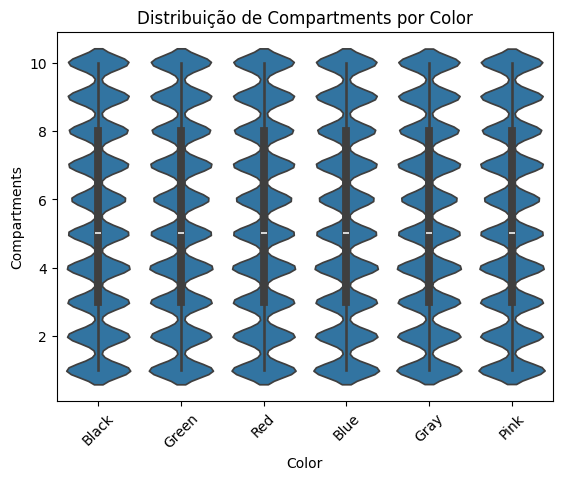

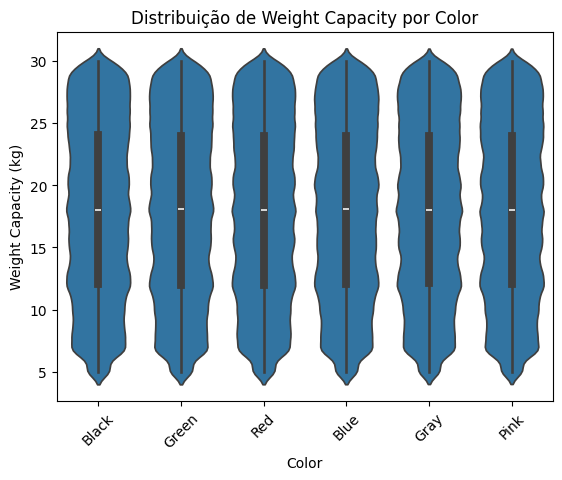

In [11]:
for column in cat_columns:
    # Exemplo de violin plot
    sns.violinplot(x=column, y='Compartments', data=df)
    plt.title(f"Distribuição de Compartments por {column}")
    plt.xticks(rotation=45)
    plt.show()

    sns.violinplot(x=column, y='Weight Capacity (kg)', data=df)
    plt.title(f"Distribuição de Weight Capacity por {column}")
    plt.xticks(rotation=45)
    plt.show()

In [12]:
import pandas as pd
import scipy.stats as stats

# Lista das variáveis categóricas
categorical_columns = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

# Função para realizar o teste qui-quadrado
def chi_square_test(df, columns):
    results = {}
    
    # Iterar pelas combinações de variáveis categóricas
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            var1 = columns[i]
            var2 = columns[j]
            
            # Criar tabela de contingência
            contingency_table = pd.crosstab(df[var1], df[var2])
            
            # Aplicar o teste qui-quadrado
            chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
            
            # Armazenar os resultados
            results[(var1, var2)] = {
                'chi2': chi2,
                'p-value': p,
                'dof': dof,
                'expected': expected
            }
    
    return results

# Realizando o teste para as variáveis categóricas
results = chi_square_test(df, categorical_columns)

# Exibindo os resultados
for key, result in results.items():
    print(f'Teste Qui-Quadrado entre {key[0]} e {key[1]}:')
    print(f'Chi2: {result["chi2"]}')
    print(f'p-value: {result["p-value"]}')
    print(f'Degrees of freedom (dof): {result["dof"]}')
    print(f'Tabela esperada:\n{result["expected"]}')
    print('-' * 50)


Teste Qui-Quadrado entre Brand e Material:
Chi2: 474.05842440112076
p-value: 7.304129035797395e-94
Degrees of freedom (dof): 12
Tabela esperada:
[[158319.57898898 170668.76305967 164509.7381757  184549.91977565]
 [148920.31130852 160536.33724768 154742.96722399 173593.38421981]
 [152207.19470531 164079.60288314 158158.36493079 177424.83748076]
 [149626.62815695 161297.74795644 155476.90045288 174416.72343373]
 [158769.28684024 171153.54885308 164977.02921664 185074.13509004]]
--------------------------------------------------
Teste Qui-Quadrado entre Brand e Size:
Chi2: 56.25451729078864
p-value: 2.5165315567066475e-09
Degrees of freedom (dof): 8
Tabela esperada:
[[227619.58841455 235239.24509116 215189.1664943 ]
 [214106.05171563 221273.33735137 202413.610933  ]
 [218831.67725558 226157.15509458 206881.16764984]
 [215121.5391958  222322.81868072 203373.64212348]
 [228266.14341845 235907.44378217 215800.41279938]]
--------------------------------------------------
Teste Qui-Quadrado en

In [13]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# Função para calcular o V de Cramer
def cramers_v(chi2, n, k, r):
    return np.sqrt(chi2 / (n * min(k - 1, r - 1)))

# Função para realizar o teste de qui-quadrado e calcular o V de Cramer
def chi_square_with_v(df, columns):
    results = {}
    
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            var1 = columns[i]
            var2 = columns[j]
            
            # Criar tabela de contingência
            contingency_table = pd.crosstab(df[var1], df[var2])
            
            # Teste Qui-quadrado
            chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
            
            # Calcular V de Cramer
            n = contingency_table.sum().sum()  # Número total de observações
            k = contingency_table.shape[0]  # Número de linhas
            r = contingency_table.shape[1]  # Número de colunas
            v = cramers_v(chi2, n, k, r)
            
            results[(var1, var2)] = {
                'chi2': chi2,
                'p-value': p,
                'dof': dof,
                'V de Cramer': v,
                'expected': expected
            }
    
    return results

# Realizando o teste de qui-quadrado e calculando o V de Cramer
results = chi_square_with_v(df, categorical_columns)

# Exibindo os resultados
for key, result in results.items():
    print(f'Teste Qui-Quadrado entre {key[0]} e {key[1]}:')
    print(f'p-value: {result["p-value"]:.4f}')
    print(f'V de Cramer: {result["V de Cramer"]:.4f}\n')

Teste Qui-Quadrado entre Brand e Material:
p-value: 0.0000
V de Cramer: 0.0069

Teste Qui-Quadrado entre Brand e Size:
p-value: 0.0000
V de Cramer: 0.0029

Teste Qui-Quadrado entre Brand e Laptop Compartment:
p-value: 0.0000
V de Cramer: 0.0031

Teste Qui-Quadrado entre Brand e Waterproof:
p-value: 0.0002
V de Cramer: 0.0026

Teste Qui-Quadrado entre Brand e Style:
p-value: 0.0000
V de Cramer: 0.0053

Teste Qui-Quadrado entre Brand e Color:
p-value: 0.0000
V de Cramer: 0.0041

Teste Qui-Quadrado entre Material e Size:
p-value: 0.0000
V de Cramer: 0.0057

Teste Qui-Quadrado entre Material e Laptop Compartment:
p-value: 0.0036
V de Cramer: 0.0020

Teste Qui-Quadrado entre Material e Waterproof:
p-value: 0.0010
V de Cramer: 0.0022

Teste Qui-Quadrado entre Material e Style:
p-value: 0.0000
V de Cramer: 0.0042

Teste Qui-Quadrado entre Material e Color:
p-value: 0.0000
V de Cramer: 0.0049

Teste Qui-Quadrado entre Size e Laptop Compartment:
p-value: 0.0000
V de Cramer: 0.0028

Teste Qui-Qu

A ideia agora é a seguinte: submeter apenas o 'train.csv' a esses testes para ver se o volume muito grande de dados compromete os resultados dos testes.

In [14]:
df_1 = pd.read_csv('../data/train.csv', index_col='id')
df_1 = df_1.dropna()
df_1

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...
299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749
299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819
299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364


In [15]:
# Realizando o teste de qui-quadrado e calculando o V de Cramer
results = chi_square_with_v(df_1, categorical_columns)

# Exibindo os resultados
for key, result in results.items():
    print(f'Teste Qui-Quadrado entre {key[0]} e {key[1]}:')
    print(f'p-value: {result["p-value"]:.4f}')
    print(f'V de Cramer: {result["V de Cramer"]:.4f}\n')

Teste Qui-Quadrado entre Brand e Material:
p-value: 0.0000
V de Cramer: 0.0085

Teste Qui-Quadrado entre Brand e Size:
p-value: 0.1125
V de Cramer: 0.0051

Teste Qui-Quadrado entre Brand e Laptop Compartment:
p-value: 0.0694
V de Cramer: 0.0059

Teste Qui-Quadrado entre Brand e Waterproof:
p-value: 0.2416
V de Cramer: 0.0047

Teste Qui-Quadrado entre Brand e Style:
p-value: 0.0877
V de Cramer: 0.0053

Teste Qui-Quadrado entre Brand e Color:
p-value: 0.5236
V de Cramer: 0.0044

Teste Qui-Quadrado entre Material e Size:
p-value: 0.0000
V de Cramer: 0.0083

Teste Qui-Quadrado entre Material e Laptop Compartment:
p-value: 0.3473
V de Cramer: 0.0037

Teste Qui-Quadrado entre Material e Waterproof:
p-value: 0.9495
V de Cramer: 0.0012

Teste Qui-Quadrado entre Material e Style:
p-value: 0.1362
V de Cramer: 0.0044

Teste Qui-Quadrado entre Material e Color:
p-value: 0.0041
V de Cramer: 0.0067

Teste Qui-Quadrado entre Size e Laptop Compartment:
p-value: 0.3095
V de Cramer: 0.0031

Teste Qui-Qu

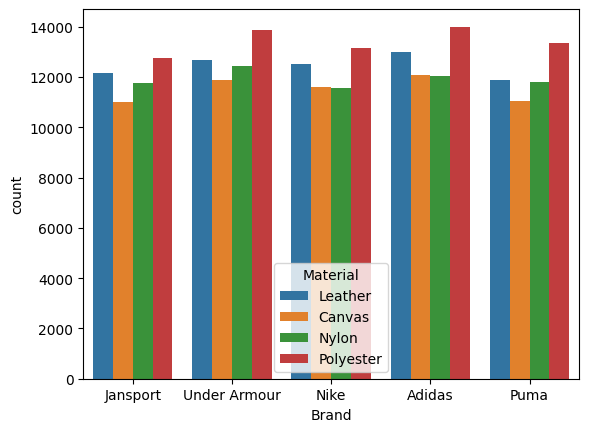

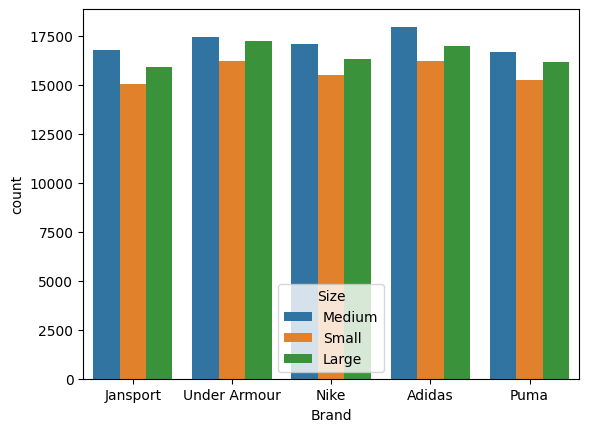

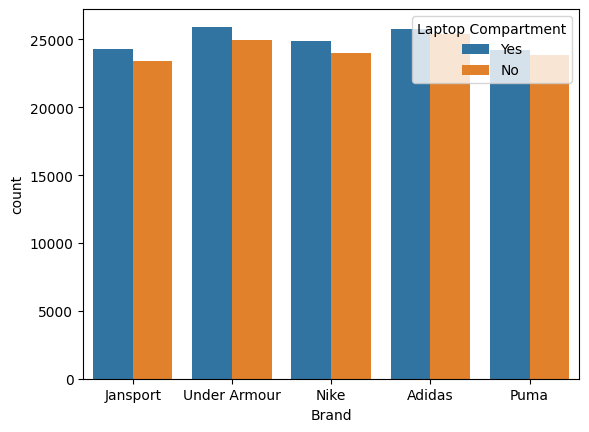

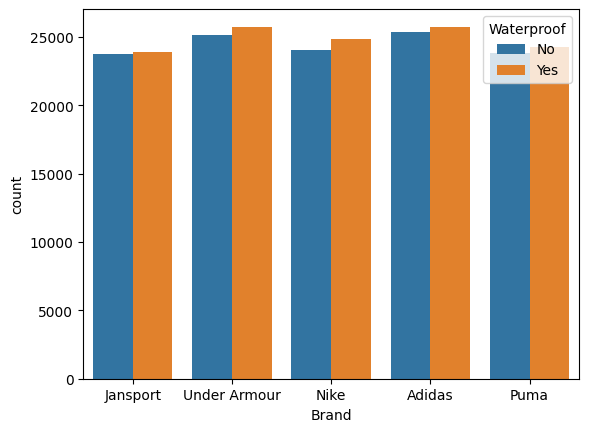

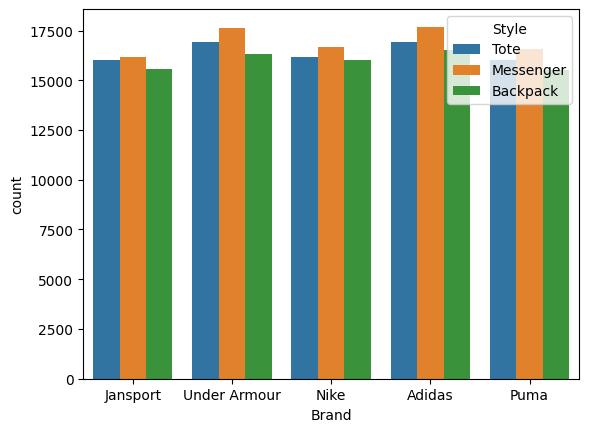

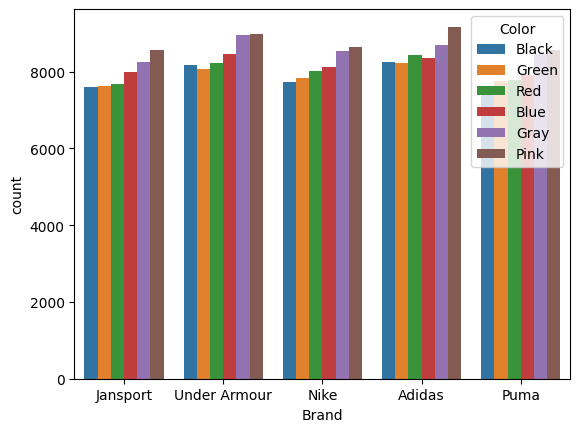

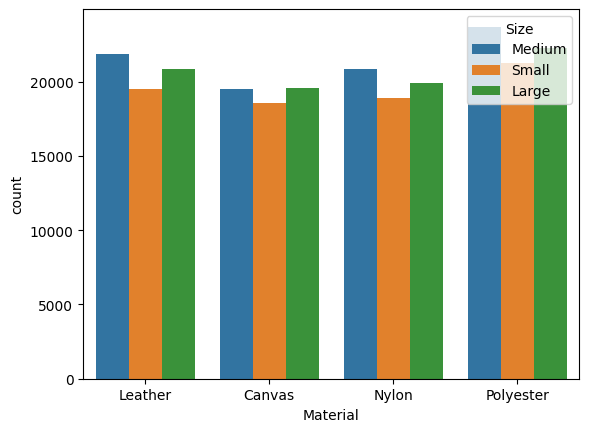

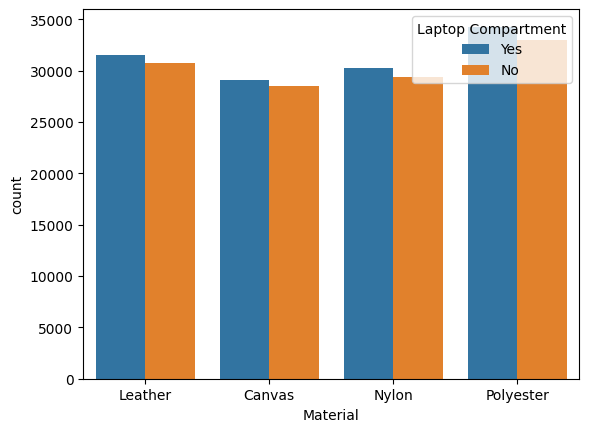

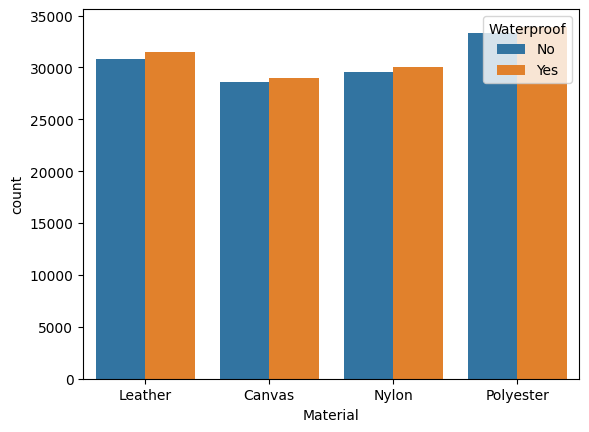

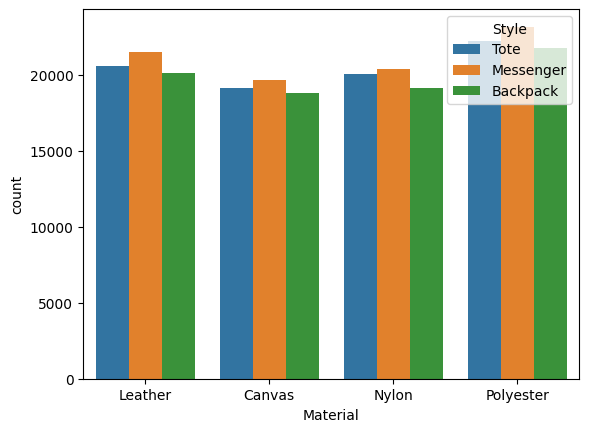

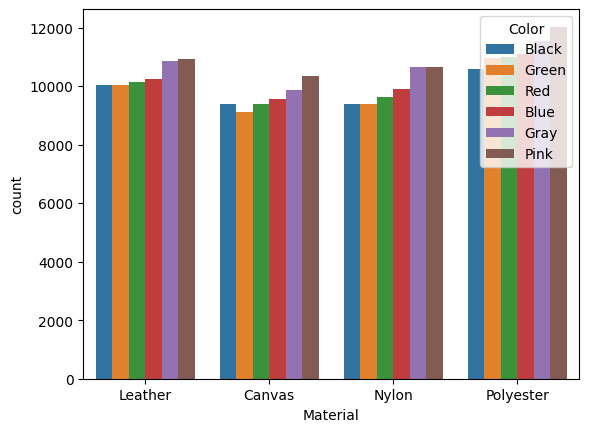

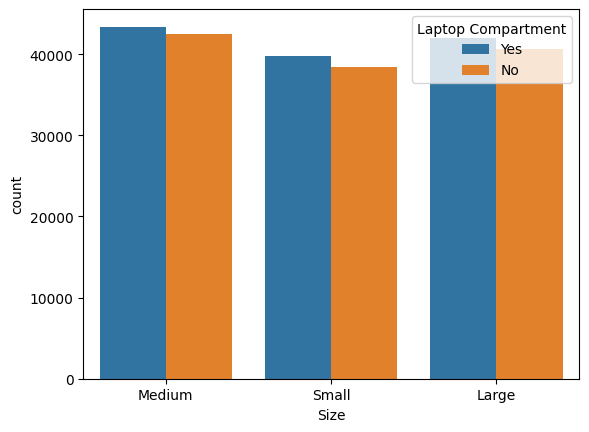

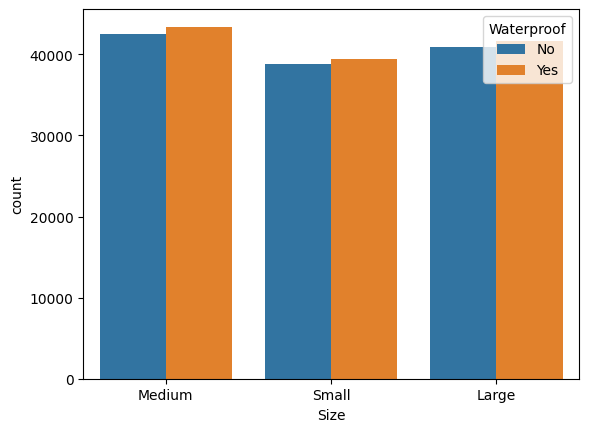

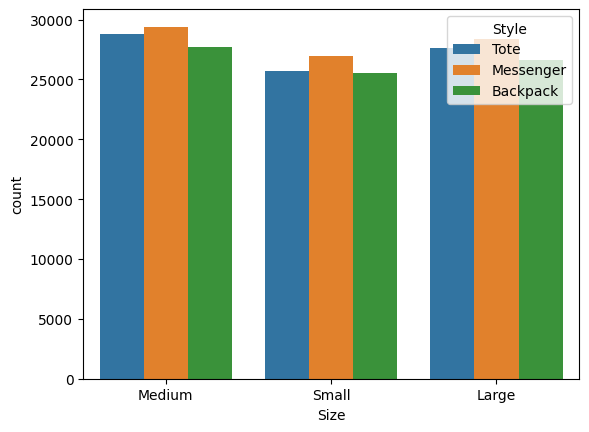

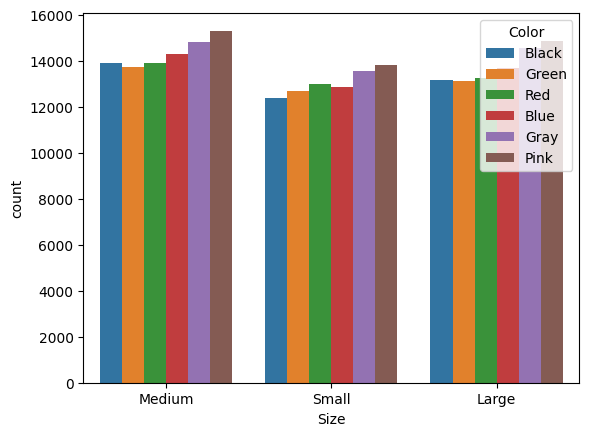

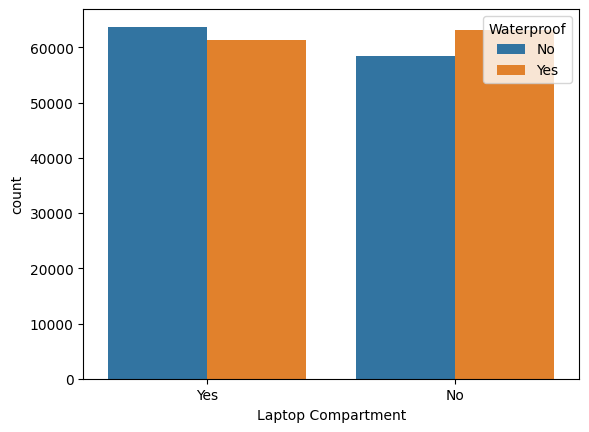

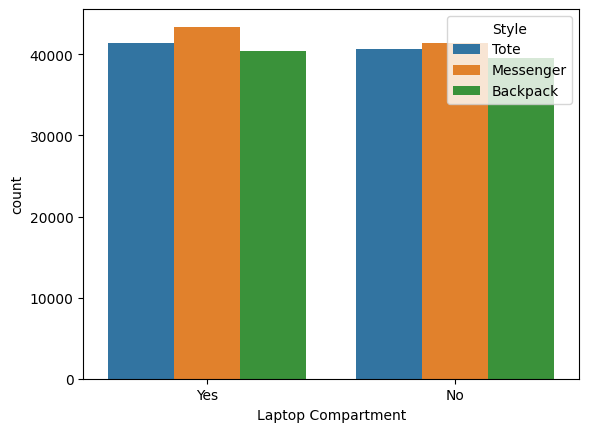

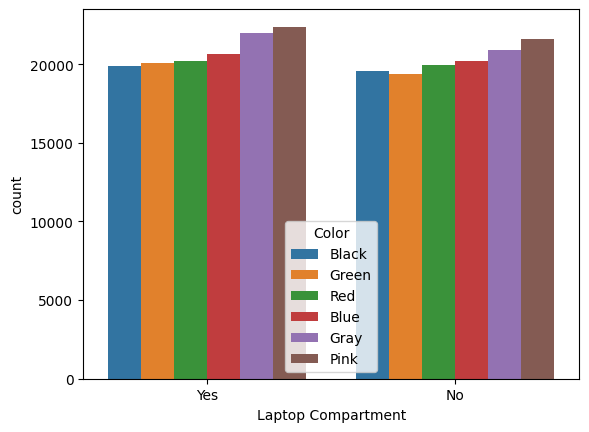

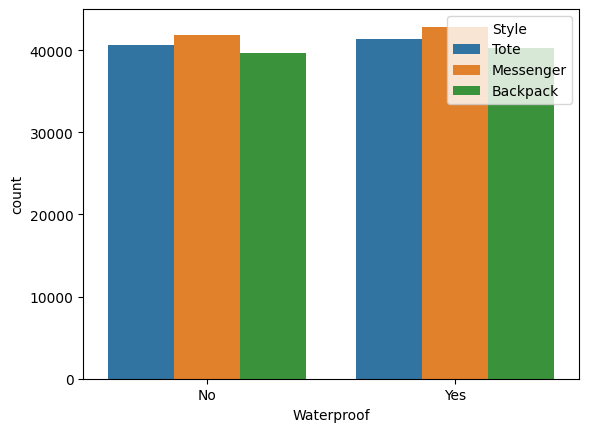

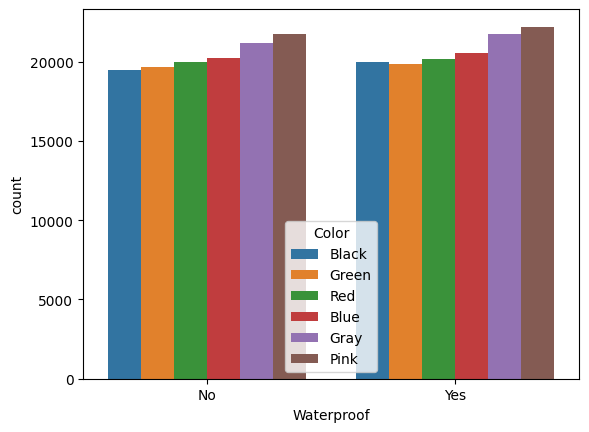

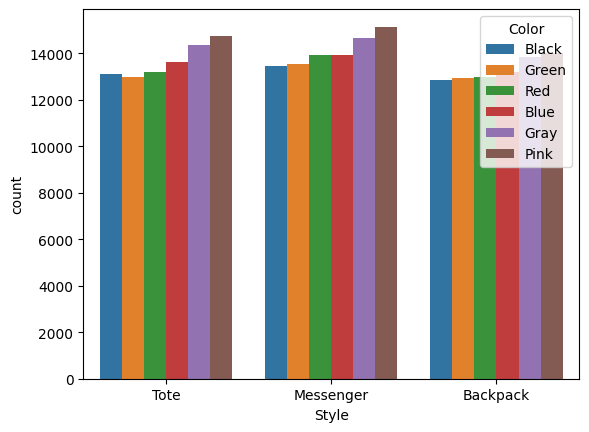

In [16]:
for i in range(len(categorical_columns) - 1):
    for j in range(i + 1, len(categorical_columns)):
        sns.countplot(x=categorical_columns[i], hue=categorical_columns[j], data=df_1)
        plt.show()

In [17]:
# Teste Kruskal-Wallis para cada combinação de variável numérica e categórica
for num_col in num_columns:
    for cat_col in cat_columns:
        kruskal_test(df_1, num_col, cat_col)

Compartments vs. Brand: 0.298
Não há diferenças significativas entre as categorias.
--------------------------------------------------
Compartments vs. Material: 0.000
Há diferenças significativas entre as categorias.
--------------------------------------------------
Compartments vs. Size: 0.001
Há diferenças significativas entre as categorias.
--------------------------------------------------
Compartments vs. Laptop Compartment: 0.502
Não há diferenças significativas entre as categorias.
--------------------------------------------------
Compartments vs. Waterproof: 0.033
Há diferenças significativas entre as categorias.
--------------------------------------------------
Compartments vs. Style: 0.001
Há diferenças significativas entre as categorias.
--------------------------------------------------
Compartments vs. Color: 0.390
Não há diferenças significativas entre as categorias.
--------------------------------------------------
Weight Capacity (kg) vs. Brand: 0.001
Há diferenças

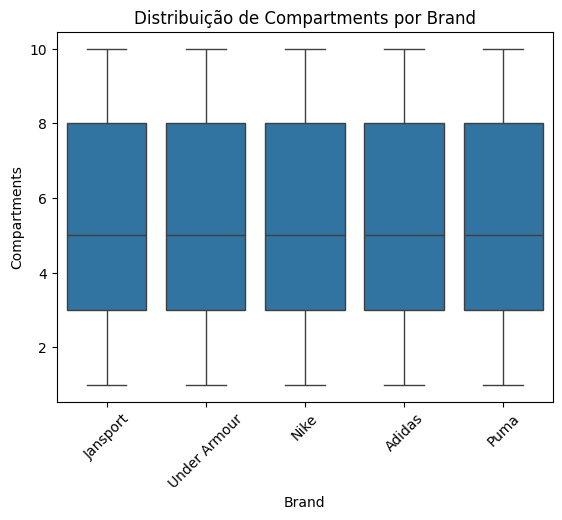

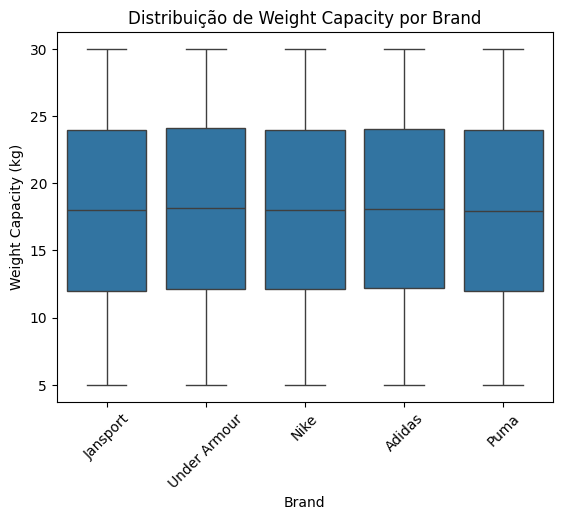

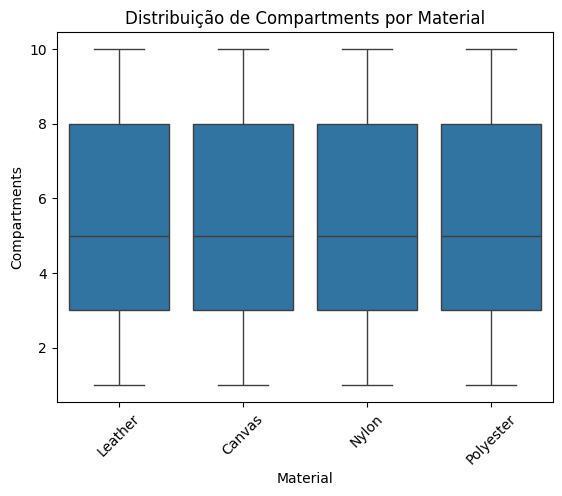

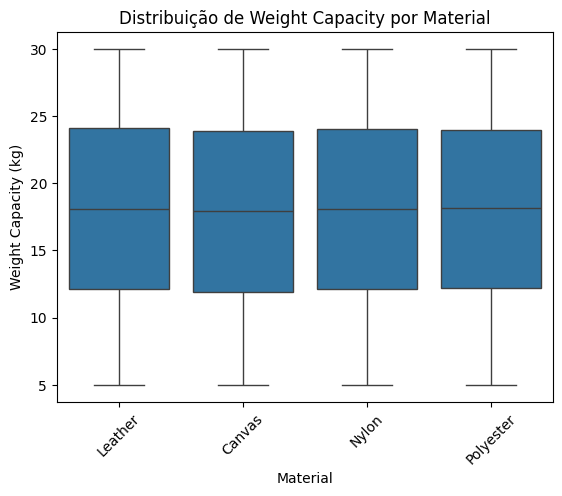

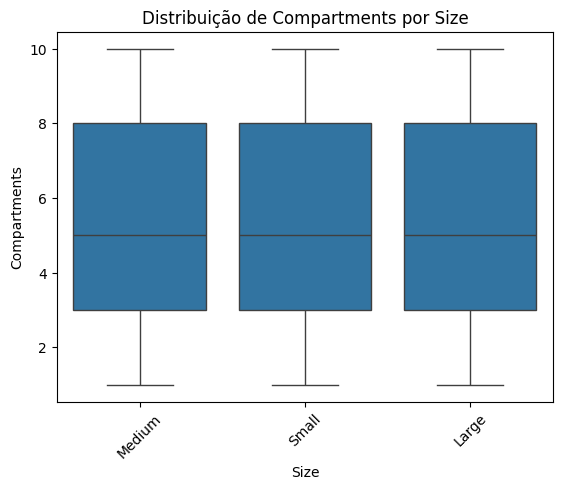

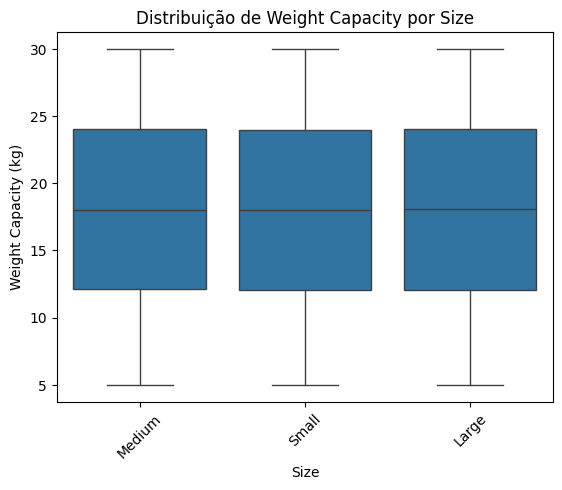

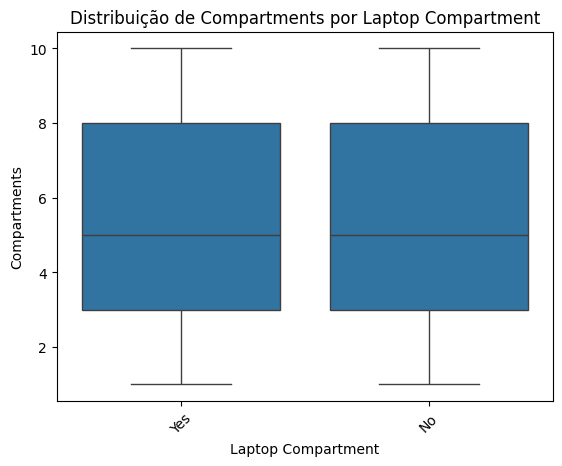

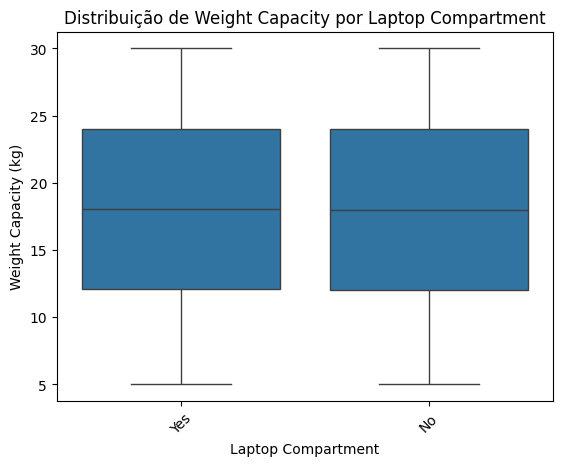

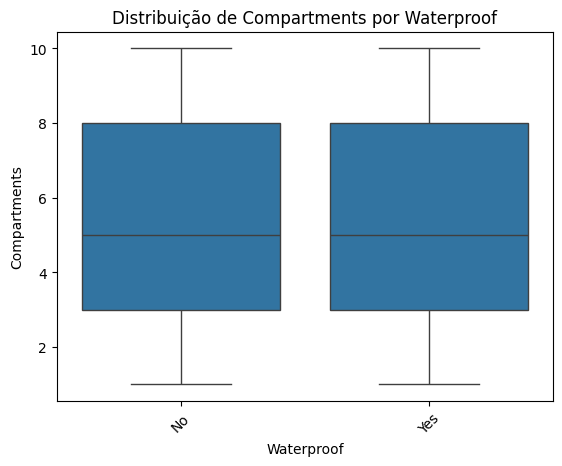

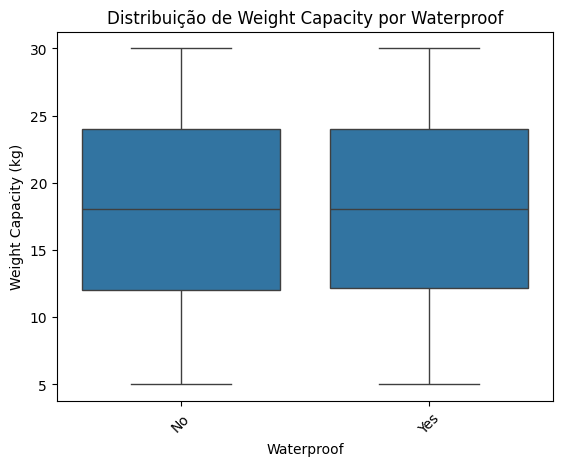

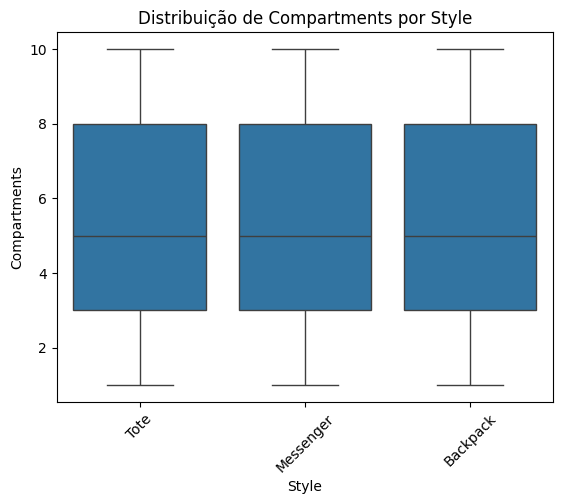

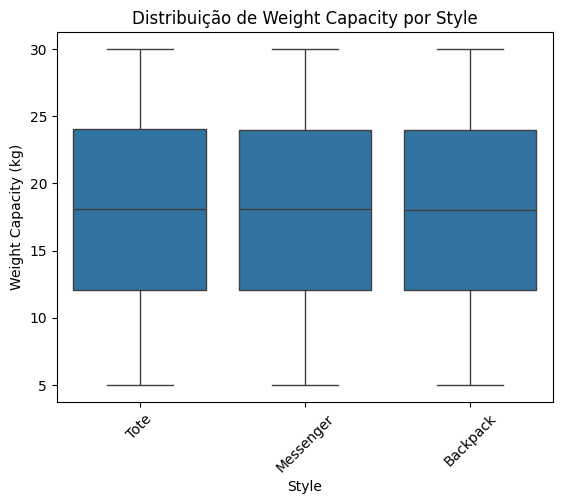

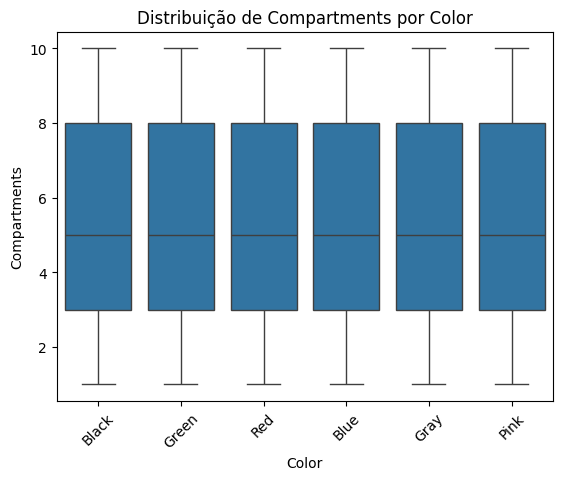

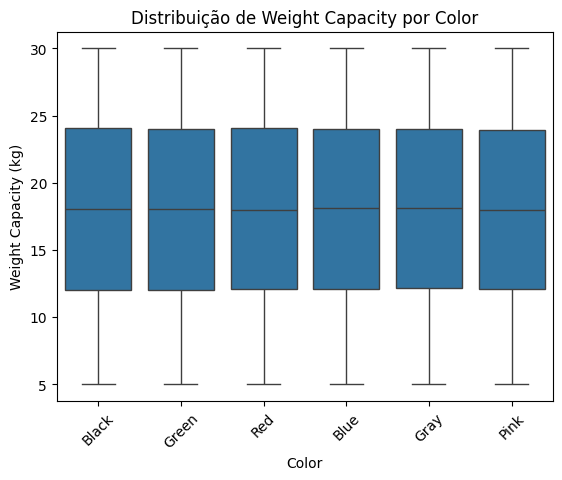

In [18]:
for column in cat_columns:
    # Boxplot para 'Compartments' por 'Brand'
    sns.boxplot(x=column, y='Compartments', data=df_1)
    plt.title(f"Distribuição de Compartments por {column}")
    plt.xticks(rotation=45)
    plt.show()

    # Boxplot para 'Compartments' por 'Material'
    sns.boxplot(x=column, y='Weight Capacity (kg)', data=df_1)
    plt.title(f"Distribuição de Weight Capacity por {column}")
    plt.xticks(rotation=45)
    plt.show()

In [19]:
for column in cat_columns:
    print(df_1.groupby(column)['Compartments'].describe())
    print("-------------------------------------------------------")

                count      mean       std  min  25%  50%  75%   max
Brand                                                              
Adidas        51138.0  5.463569  2.885325  1.0  3.0  5.0  8.0  10.0
Jansport      47710.0  5.441459  2.885317  1.0  3.0  5.0  8.0  10.0
Nike          48866.0  5.463410  2.883754  1.0  3.0  5.0  8.0  10.0
Puma          48099.0  5.445186  2.893821  1.0  3.0  5.0  8.0  10.0
Under Armour  50873.0  5.431113  2.883970  1.0  3.0  5.0  8.0  10.0
-------------------------------------------------------
             count      mean       std  min  25%  50%  75%   max
Material                                                        
Canvas     57618.0  5.483096  2.882830  1.0  3.0  5.0  8.0  10.0
Leather    62233.0  5.416178  2.893765  1.0  3.0  5.0  8.0  10.0
Nylon      59633.0  5.430785  2.892680  1.0  3.0  5.0  8.0  10.0
Polyester  67202.0  5.466266  2.876640  1.0  3.0  5.0  8.0  10.0
-------------------------------------------------------
          count      m

In [20]:
for column in cat_columns:
    print(df_1.groupby(column)['Weight Capacity (kg)'].describe())
    print("-------------------------------------------------------")

                count       mean       std  min        25%        50%  \
Brand                                                                   
Adidas        51138.0  18.068592  6.936442  5.0  12.203635  18.111489   
Jansport      47710.0  17.980843  6.974698  5.0  12.007768  18.018767   
Nike          48866.0  17.995431  6.932078  5.0  12.137000  17.988569   
Puma          48099.0  17.929602  6.996512  5.0  11.983880  17.929069   
Under Armour  50873.0  18.100401  6.984470  5.0  12.127953  18.170615   

                    75%        max  
Brand                               
Adidas        24.055094  29.996888  
Jansport      23.977341  29.994993  
Nike          23.946334  29.997986  
Puma          23.928543  29.999796  
Under Armour  24.126783  29.995042  
-------------------------------------------------------
             count       mean       std  min        25%        50%        75%  \
Material                                                                        
Canvas     

In [21]:
df_1 = pd.read_csv("../data/train.csv", index_col='id')
df_2 = pd.read_csv("../data/training_extra.csv", index_col='id')
df = pd.concat([df_1, df_2], axis=0)
df

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...
4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470


In [22]:
df.columns

Index(['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')

In [23]:
col = 'Waterproof'
print(df[col].value_counts(normalize=True) * 100)
print(f"\nNaN values percentual: {((df[col].isna().sum() / len(df)) * 100):.2f}")

Waterproof
Yes    50.492514
No     49.507486
Name: proportion, dtype: float64

NaN values percentual: 2.36


Não encontrei associação entre as variáveis que pudesse orientar o preenchimento dos valores NaN de cada coluna. Existem duas alternativas. Primeira: posso utilizar um imputer como o KNNImputer.Para isso, no entanto, eu preciso transformar as variáveis categóricas em números. Isso trará, no entanto, algumas dificuldades adicionais. Segunda: posso ter uma abordagem mais conservadora e simplesmente preencher os valores NaN de forma aleatórias mas respeitando a distribuição das categorias. Ou seja, em vez de preencher 'Waterproof' com a moda, preencho com a distribuição que já existe das categorias. Assim, por exemplo, 'Waterproof' tem distribuição de 50.5% para Yes e 49.5% para No. Os valores NaN desta variável serão dividios em dois grupos: um com 50.5% dos valores que serão preenchidos com Yes e o restante com No.

### CARREGANDO OS DATASETS E CONCATENANDO-OS

In [2]:
df_1 = pd.read_csv("../data/train.csv", index_col='id')
df_2 = pd.read_csv("../data/training_extra.csv", index_col='id')
df = pd.concat([df_1, df_2], axis=0)
df

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...
4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470


### TRANSFORMANDO 'COMPARTMENTS' EM CATEGÓRICA

In [3]:
df_prep = df.copy()
df_prep['Compartments'] = df_prep['Compartments'].astype(int).astype(object)
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 4194317
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 object 
 1   Material              object 
 2   Size                  object 
 3   Compartments          object 
 4   Laptop Compartment    object 
 5   Waterproof            object 
 6   Style                 object 
 7   Color                 object 
 8   Weight Capacity (kg)  float64
 9   Price                 float64
dtypes: float64(2), object(8)
memory usage: 335.2+ MB


### PREENCHENDO OS VALORES NAN COM A MESMA DISTRIBUIÇÃO DAS CATEGORIAS

In [4]:
df_prep.isna().sum()

Brand                   126758
Material                110962
Size                     87785
Compartments                 0
Laptop Compartment       98533
Waterproof               94324
Style                   104180
Color                   133617
Weight Capacity (kg)      1808
Price                        0
dtype: int64

In [5]:
cat_columns = ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

for column in cat_columns:
    # Mostrando a distribuição antes do preenchimento
    category_percent = df_prep[column].value_counts(normalize=True)
    print("Distriubuição antes do preenchimento")
    print(category_percent * 100)
    print("-------------------------------------------")

    # Preenchendo valores NaN com base nas proporções existentes entre as categorias
    n_nan = df_prep[column].isna().sum()
    categories = category_percent.index
    proportions = category_percent.values

    new_values = np.random.choice(categories, size=n_nan, p=proportions)

    df_prep.loc[df_prep[column].isna(), column] = new_values

    # Mostrando a distribuição depois do preenchimento
    category_percent = df_prep[column].value_counts(normalize=True)
    print("Distriubuição depois do preenchimento")
    print(category_percent * 100)
    print("-------------------------------------------")


Distriubuição antes do preenchimento
Brand
Under Armour    20.711637
Adidas          20.607308
Nike            19.764580
Puma            19.541468
Jansport        19.375006
Name: proportion, dtype: float64
-------------------------------------------
Distriubuição depois do preenchimento
Brand
Under Armour    20.713599
Adidas          20.610302
Nike            19.761947
Puma            19.545715
Jansport        19.368438
Name: proportion, dtype: float64
-------------------------------------------
Distriubuição antes do preenchimento
Material
Polyester    27.318690
Leather      25.137690
Nylon        24.274262
Canvas       23.269358
Name: proportion, dtype: float64
-------------------------------------------
Distriubuição depois do preenchimento
Material
Polyester    27.317304
Leather      25.135855
Nylon        24.276009
Canvas       23.270831
Name: proportion, dtype: float64
-------------------------------------------
Distriubuição antes do preenchimento
Size
Medium    34.672355
Large 

In [6]:
df_prep['Weight Capacity (kg)'] = df_prep['Weight Capacity (kg)'].fillna(df_prep['Weight Capacity (kg)'].mean())
df_prep.isna().sum()

Brand                   0
Material                0
Size                    0
Compartments            0
Laptop Compartment      0
Waterproof              0
Style                   0
Color                   0
Weight Capacity (kg)    0
Price                   0
dtype: int64

### ENGENHARIA DE ATRIBUTOS: APLICAR O ONE HOT ENCODING NAS VARIÁVEIS CATEGÓRICAS E A PADRONIZAÇÃO PARA AS VARIÁVEIS NUMÉRICAS

In [7]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 4194317
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 object 
 1   Material              object 
 2   Size                  object 
 3   Compartments          object 
 4   Laptop Compartment    object 
 5   Waterproof            object 
 6   Style                 object 
 7   Color                 object 
 8   Weight Capacity (kg)  float64
 9   Price                 float64
dtypes: float64(2), object(8)
memory usage: 335.2+ MB


In [8]:
df_eng = df_prep.copy()
cat_columns = df_eng.select_dtypes(include=['object']).columns
for column in cat_columns:
    df_eng = pd.get_dummies(df_eng, columns=[column], prefix=['dum'], dtype=int)

scaler = MinMaxScaler()
df_eng['Weight Capacity (kg)'] = scaler.fit_transform(df_eng[['Weight Capacity (kg)']])

In [9]:
df_eng

,Weight Capacity (kg),Price,dum_Adidas,dum_Jansport,dum_Nike,dum_Puma,dum_Under Armour,dum_Canvas,dum_Leather,dum_Nylon,...,dum_Yes,dum_Backpack,dum_Messenger,dum_Tote,dum_Black,dum_Blue,dum_Gray,dum_Green,dum_Pink,dum_Red
id,,,,,,,,,,,,,,,,,,,,,
0,0.264469,112.15875,0,1,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
1,0.883141,68.88056,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
2,0.465750,39.17320,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,0.317489,80.60793,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
4,0.509974,86.02312,1,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4194313,0.923925,104.74460,0,0,1,0,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
4194314,0.495181,122.39043,0,0,0,1,0,0,1,0,...,1,0,0,1,0,1,0,0,0,0
4194315,0.481508,148.18470,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Dividindo as variáveis independentes (X) e o target (y)
X = df_eng.drop('Price', axis=1)  # Considerando 'Price' como o target
y = df_eng['Price']

# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dicionário de modelos a serem testados
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso()
}

# Função para calcular o RMSE
def calculate_rmse(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Testando cada modelo e imprimindo o RMSE
for name, model in models.items():
    rmse = calculate_rmse(model, X_train, X_test, y_train, y_test)
    print(f'{name} - RMSE: {rmse:.4f}')


Linear Regression - RMSE: 38.8947
Ridge - RMSE: 38.8947
Lasso - RMSE: 38.9157


In [11]:
from sklearn.model_selection import GridSearchCV

# Defina os parâmetros a serem afinados
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Defina os modelos
ridge = Ridge()

# GridSearch para Ridge
ridge_search = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
ridge_search.fit(X_train, y_train)
print("Melhores parâmetros para Ridge:", ridge_search.best_params_)
print("Melhor RMSE para Ridge:", -ridge_search.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores parâmetros para Ridge: {'alpha': 100}
Melhor RMSE para Ridge: 38.922444258523754


In [12]:
# Defina os parâmetros a serem afinados
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Defina os modelos
lasso = Lasso()

# GridSearch para Lasso
lasso_search = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
lasso_search.fit(X_train, y_train)
print("Melhores parâmetros para Lasso:", lasso_search.best_params_)
print("Melhor RMSE para Lasso:", -lasso_search.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores parâmetros para Lasso: {'alpha': 0.01}
Melhor RMSE para Lasso: 38.92253949592948


In [13]:

ridge_tuned = Ridge(alpha=100)
ridge_tuned.fit(X_train, y_train)
y_pred = ridge_tuned.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Ridge: {rmse:.4f}")

Ridge: 38.8947


In [14]:
lasso_tuned = Lasso(alpha=0.01)
lasso_tuned.fit(X_train, y_train)
y_pred = lasso_tuned.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Lasso: {rmse:.4f}")

Lasso: 38.8948


In [18]:
from itertools import combinations

# Definindo as colunas que você vai usar
columns = ['Weight Capacity (kg)', 'Price', 'dum_Adidas', 'dum_Jansport', 
           'dum_Nike', 'dum_Puma', 'dum_Under Armour', 'dum_Canvas', 
           'dum_Leather', 'dum_Nylon', 'dum_Polyester', 'dum_Large', 
           'dum_Medium', 'dum_Small', 'dum_1', 'dum_2', 'dum_3', 'dum_4', 
           'dum_5', 'dum_6', 'dum_7', 'dum_8', 'dum_9', 'dum_10', 'dum_No', 
           'dum_Yes', 'dum_No', 'dum_Yes', 'dum_Backpack', 'dum_Messenger', 
           'dum_Tote', 'dum_Black', 'dum_Blue', 'dum_Gray', 'dum_Green', 
           'dum_Pink', 'dum_Red']

# Extraindo as variáveis preditoras e a variável target
X = df_eng[columns].drop('Price', axis=1)
y = df_eng['Price']

# Separando os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializando os modelos
ridge = Ridge(alpha=100)
lasso = Lasso(alpha=0.01)

# Inicializando uma lista para armazenar os resultados
results = []

# Iterando por todas as combinações possíveis de colunas
for i in range(1, len(columns)):
    for combo in combinations(columns, i):
        # Excluindo 'Price' da combinação
        if 'Price' in combo:
            continue
        
        X_subset = X_train[list(combo)]  # Subconjunto das colunas selecionadas
        # Ajustando e avaliando o modelo Ridge
        ridge.fit(X_subset, y_train)
        ridge_preds = ridge.predict(X_test[list(combo)])
        ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))  # Calculando o RMSE
        
        # Ajustando e avaliando o modelo Lasso
        lasso.fit(X_subset, y_train)
        lasso_preds = lasso.predict(X_test[list(combo)])
        lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))  # Calculando o RMSE
        
        # Armazenando os resultados
        results.append({
            'Columns': combo,
            'Ridge RMSE': ridge_rmse,
            'Lasso RMSE': lasso_rmse
        })

# Convertendo os resultados para um DataFrame
results_df = pd.DataFrame(results)

# Exibindo os resultados
print(results_df)

KeyboardInterrupt: 